In [1]:
import torch
from collections import OrderedDict

salicon_ckpt_path = 'train_dinogaze_attentionhead/salicon_pretraining/final.pth'
salicon_state_dict = torch.load(salicon_ckpt_path, map_location='cpu')

print("--- Keys in SALICON Checkpoint ---")
for key in salicon_state_dict.keys():
    print(key)

# Optional: Load your current base model definition (on CPU) and print its keys
from train_dinogaze_ddp import build_saliency_network, build_fixation_selection_network # Adjust import
C_in = 4608 # Assuming ViT-G
saliency_net = build_saliency_network(C_in, add_sa_head=True)
fixsel_net = build_fixation_selection_network(scanpath_features=0)
print("\n--- Keys in Current Saliency Network Def ---")
for key in saliency_net.state_dict().keys():
   print(key)
print("\n--- Keys in Current FixSel Network Def ---")
for key in fixsel_net.state_dict().keys():
   print(key)

--- Keys in SALICON Checkpoint ---
features.backbone.cls_token
features.backbone.pos_embed
features.backbone.mask_token
features.backbone.patch_embed.proj.weight
features.backbone.patch_embed.proj.bias
features.backbone.blocks.0.norm1.weight
features.backbone.blocks.0.norm1.bias
features.backbone.blocks.0.attn.qkv.weight
features.backbone.blocks.0.attn.qkv.bias
features.backbone.blocks.0.attn.proj.weight
features.backbone.blocks.0.attn.proj.bias
features.backbone.blocks.0.ls1.gamma
features.backbone.blocks.0.norm2.weight
features.backbone.blocks.0.norm2.bias
features.backbone.blocks.0.mlp.w12.weight
features.backbone.blocks.0.mlp.w12.bias
features.backbone.blocks.0.mlp.w3.weight
features.backbone.blocks.0.mlp.w3.bias
features.backbone.blocks.0.ls2.gamma
features.backbone.blocks.1.norm1.weight
features.backbone.blocks.1.norm1.bias
features.backbone.blocks.1.attn.qkv.weight
features.backbone.blocks.1.attn.qkv.bias
features.backbone.blocks.1.attn.proj.weight
features.backbone.blocks.1.att

loaded train_dinogaze_simple/MIT1003_twosize/scanpaths_twosize.pkl written Mon May  5 15:10:25 2025


Using cache found in /home/mmorello/.cache/torch/hub/facebookresearch_dinov2_main


Stimuli metadata shape H, W: (768, 1024)
Loaded image shape H, W:   (768, 1024)
Stimulus index n: 44
Filename from stimuli object: /home/mmorello/Decoding_Neural_Dynamics_of_Visual_Perceptual_Segmentation/DeepGaze/train_dinogaze_simple/MIT1003_twosize/stimuli/i105415081.jpeg
Image path being used:        /home/mmorello/Decoding_Neural_Dynamics_of_Visual_Perceptual_Segmentation/DeepGaze/train_dinogaze_simple/MIT1003_twosize/stimuli/i105415081.jpeg
Plotting 114 fixations after filtering for bounds.
Mask sum for stimulus 44: 113.0
Number of valid fixations plotted: 114


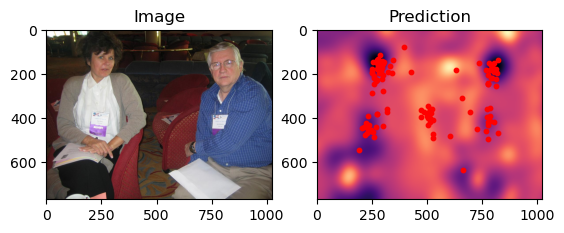

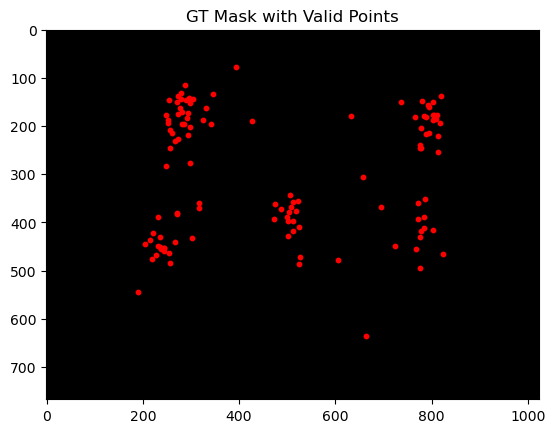

In [17]:
import sys, torch, matplotlib.pyplot as plt
from PIL import Image
from train_dinogaze_ddp import DeepGazeIII, DinoV2Backbone, build_saliency_network
from torchvision.transforms.functional import to_tensor
from pathlib import Path # Import Path
import cloudpickle as cp # Import cp (assuming cloudpickle)
import numpy as np # Import numpy
import imageio.v3 as iio
import pysaliency
import time
import os

conv_dir = Path("train_dinogaze_simple/MIT1003_twosize")
stim_dir = conv_dir / "stimuli"               # created by your conversion

# ❶  collect the files and their shapes
filenames = sorted(p.as_posix()               # str paths – required
                   for p in stim_dir.iterdir() if p.suffix.lower() in [".jpg",".jpeg",".png",".ppm"])
shapes    = [iio.imread(p).shape for p in filenames]

ckpt = 'train_dinogaze_simple/salicon_pretraining/final.pth'
#image_path = 'train_dinogaze_simple/MIT1003_twosize/stimuli/i2299063277.jpeg'
#image_path = 'train_dinogaze_simple/MIT1003_twosize/stimuli/i1116123355.jpeg'
image_path = 'train_dinogaze_simple/MIT1003_twosize/stimuli/i105415081.jpeg'
#image_path = 'train_dinogaze_simple/MIT1003_twosize/stimuli/i2057541.jpeg'
#image_path = 'train_dinogaze_simple/MIT1003_twosize/stimuli/i1308682205.jpeg'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
conv_dir = Path("train_dinogaze_simple/MIT1003_twosize")
stimuli   = cp.load(open(conv_dir / "stimuli.pkl", "rb"))      # <-- load cache
fixations = cp.load(open(conv_dir / "scanpaths_twosize.pkl","rb"))
pkl_path = conv_dir / "scanpaths_twosize.pkl"
print("loaded", pkl_path,
      "written", time.ctime(os.path.getmtime(pkl_path)))
img_name = "i105415081.jpeg"

class FixationSelectionIdentity(torch.nn.Module):
    def forward(self, inputs):
        features, _ = inputs   # unpack (x, y)
        return features

# --- build model skeleton that matches your training config -------------
backbone = DinoV2Backbone(layers=[-3, -2, -1],
                          model_name='dinov2_vitl14',
                          freeze=True)
C_in = len(backbone.layers) * backbone.num_channels
model = DeepGazeIII(
          features=backbone,
          saliency_network=build_saliency_network(C_in),
          scanpath_network=None,
          fixation_selection_network=FixationSelectionIdentity(),
          downsample=1,
          readout_factor=7,
          saliency_map_factor=4,
          included_fixations=[]
        ).to(device)

# load weights (need *before* .eval() so missing keys are reported clearly)
sd = torch.load(ckpt, map_location=device)
model.load_state_dict(sd, strict=False)
model.eval()                           # now safe

# --- dummy zero centre-bias (function definition, not used directly here) ----
# def zeros_cb(n, H, W):
#     return torch.zeros((n, H, W), device=device)

# --- Get stimulus index and dimensions ------------------------------------
#n = stimuli.filenames.index((conv_dir/"stimuli"/img_name).as_posix())
# build an absolute Path for your target image
target = (conv_dir / "stimuli" / img_name).resolve()

# convert every stored filename to an absolute Path as well
filenames_as_paths = [Path(p).resolve() for p in stimuli.filenames]

# now the lookup will succeed
n = filenames_as_paths.index(target)

H, W, _ = stimuli.shapes[n]

img = Image.open(image_path).convert("RGB")
img_H, img_W = img.height, img.width # Get dims directly from loaded image
print(f"Stimuli metadata shape H, W: ({H}, {W})")
print(f"Loaded image shape H, W:   ({img_H}, {img_W})")
assert H == img_H and W == img_W, "Mismatch between stimuli metadata shape and loaded image shape!"
# Also verify the fixations you extracted are for the right n
print(f"Stimulus index n: {n}")
image_path = (conv_dir / "stimuli" / img_name).resolve().as_posix()

print(f"Filename from stimuli object: {stimuli.filenames[n]}")
print(f"Image path being used:        {image_path}")
assert stimuli.filenames[n] == image_path, "Mismatch between index n and image_path!"


# --- Build the GT fixation mask (Robust version) ---------------------------
mask = torch.zeros((H, W), dtype=torch.float32, device='cpu') # Create mask on CPU is fine

# Select coordinates for the current stimulus
stimulus_indices_mask = (fixations.n == n)
xs_for_stimulus = fixations.x[stimulus_indices_mask]
ys_for_stimulus = fixations.y[stimulus_indices_mask]

# Round to integers
xs_int = np.round(xs_for_stimulus).astype(int)
ys_int = np.round(ys_for_stimulus).astype(int)

# Filter out indices that are out of bounds
valid_x_indices = (xs_int >= 0) & (xs_int < W)
valid_y_indices = (ys_int >= 0) & (ys_int < H)
valid_indices = valid_x_indices & valid_y_indices

# Get the final valid integer coordinates
final_xs_int = xs_int[valid_indices]
final_ys_int = ys_int[valid_indices]

print(f"Plotting {len(final_xs_int)} fixations after filtering for bounds.")

# Assign 1.0 to the mask only at valid locations
if len(final_xs_int) > 0: # Check if there are any valid fixations
    mask[final_ys_int, final_xs_int] = 1.0


# --------- load stimulus & predict ---------------
img   = Image.open(conv_dir/"stimuli"/img_name).convert("RGB")
img_t = to_tensor(img).unsqueeze(0).to(device)

# Create the actual center bias tensor needed for the model call
cb = torch.zeros((1, H, W), device=device)
with torch.no_grad():
    # The model output is log_density, apply exp() for density/probability
    log_pred = model(img_t, cb)
    pred = log_pred.exp().squeeze(0).cpu() # Squeeze batch dim, move to CPU


# --- Optional: Print mask sum to verify ---
print(f"Mask sum for stimulus {n}: {mask.sum().item()}")
print(f"Number of valid fixations plotted: {len(final_xs_int)}")

#--- (The plotting code from the previous steps would go here, using img, pred, mask, xs_plot, ys_plot) ---
#Example (replace with your actual plotting code):
import torch.nn.functional as F
plt.figure()
plt.subplot(1,2,1); plt.imshow(img); plt.title('Image')
plt.subplot(1,2,2); plt.imshow(pred, cmap='magma'); plt.title('Prediction')
plt.scatter(final_xs_int, final_ys_int, c='r', s=10) # Plot valid points
plt.show()

plt.imshow(mask, cmap='gray')
plt.scatter(final_xs_int, final_ys_int, c='r', s=10)
plt.title('GT Mask with Valid Points')
plt.show()

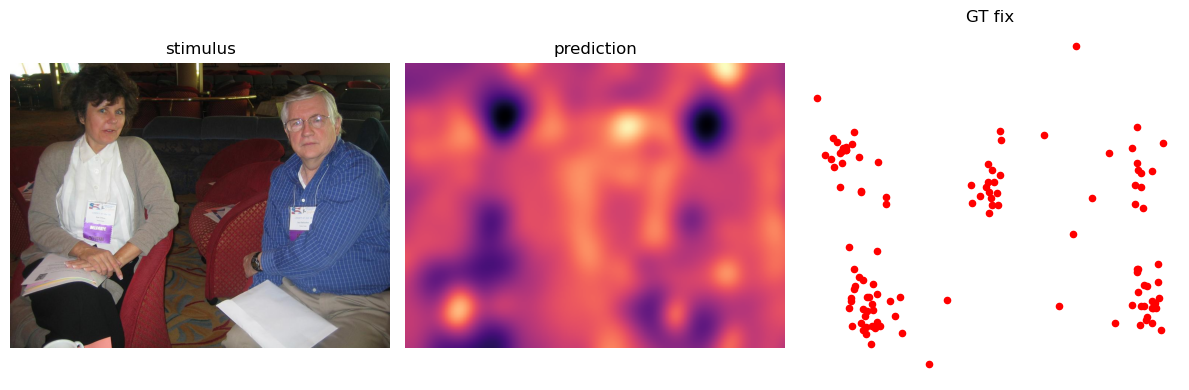

In [18]:
import torch, matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from torchvision.transforms.functional import to_tensor
import cloudpickle as cpickle
import numpy as np

# --------------- build a binary fixation map -----------------
H, W, _ = stimuli.shapes[n] # Get dimensions for the target stimulus
mask = torch.zeros((H, W), dtype=torch.float32)

# Use boolean indexing on the flat arrays from ScanpathFixations
# scanpaths.n contains the stimulus index for EACH fixation in the flat arrays
stimulus_indices_mask = (fixations.n == n)

# Select the x and y coordinates ONLY for the target stimulus
xs_for_stimulus = fixations.x[stimulus_indices_mask]
ys_for_stimulus = fixations.y[stimulus_indices_mask]

# Convert coordinates to integers for indexing the mask
# Ensure coordinates are rounded correctly and cast to int
xs_int = np.round(xs_for_stimulus).astype(int)
ys_int = np.round(ys_for_stimulus).astype(int)

# Filter out indices that might be out of bounds after scaling/clamping/rounding
valid_x_indices = (xs_int >= 0) & (xs_int < W)
valid_y_indices = (ys_int >= 0) & (ys_int < H)
valid_indices = valid_x_indices & valid_y_indices

final_xs_int = xs_int[valid_indices]
final_ys_int = ys_int[valid_indices]

# Set the corresponding pixels in the mask to 1
if len(final_xs_int) > 0: # Check if there are any valid fixations
    mask[final_ys_int, final_xs_int] = 1.0

# --------------- run the model (unchanged) --------------------
img   = Image.open(image_path).convert("RGB")
img_t = to_tensor(img).unsqueeze(0).to(device)

cb    = torch.zeros((1, H, W), device=device)        # full-res centre-bias
with torch.no_grad():
    pred = model(img_t, cb).exp().squeeze().cpu()

# --------------- plot -----------------------------------------
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img);              plt.title("stimulus");   plt.axis('off')
plt.subplot(1,3,2); plt.imshow(pred, cmap='magma');plt.title("prediction"); plt.axis('off')
plt.subplot(1,3,3); plt.scatter(final_xs_int, final_ys_int, s=20, c='r', marker='o');plt.title("GT fix");      plt.axis('off')
plt.tight_layout(); plt.show()


In [19]:
#print("xs in image?", (xs >= 0).all(), (xs < W).all())
#print("ys in image?", (ys >= 0).all(), (ys < H).all())
#print("#fixations:", len(xs))
#print("mask sum :", mask.sum().item())


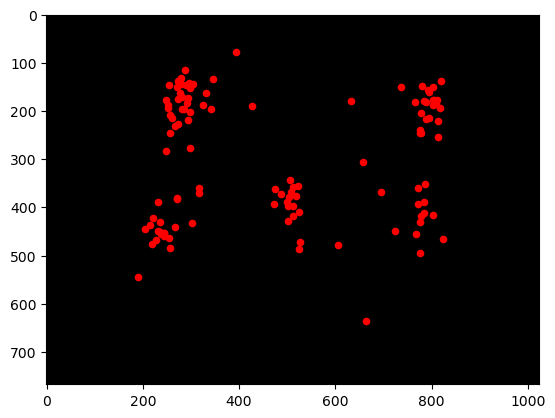

In [20]:
plt.imshow(mask, cmap='gray')
plt.scatter(final_xs_int, final_ys_int, s=20, c='r', marker='o')   # each fixation = 20-px red dot


In [21]:
def convert_fixation_trains(stimuli, fixations, is_master: bool):
    """
    Converts fixation coordinates and filters attributes for FixationTrains,
    incorporating vectorized scaling and stricter attribute checks.
    """
    # --- Initial Checks ---
    if stimuli is None or not hasattr(stimuli, 'shapes'):
        _logger.error("Stimuli object is None or missing 'shapes'. Cannot convert fixations.")
        return None
    core_attrs = ['train_xs', 'train_ys', 'train_ts', 'train_ns', 'train_subjects']
    if not all(hasattr(fixations, attr) for attr in core_attrs):
        _logger.error("Input fixations object is missing one or more core train_* attributes.")
        return None

    if is_master: _logger.info("Converting fixation coordinates...")

    try:
        # --- Pull out the original 2D scanpath matrices ---
        train_xs       = np.asarray(fixations.train_xs,      dtype=float)   # shape (T, L)
        train_ys       = np.asarray(fixations.train_ys,      dtype=float)   # shape (T, L)
        train_ts       = np.asarray(fixations.train_ts,      dtype=float)   # shape (T, L)
        train_ns       = np.asarray(fixations.train_ns,      dtype=int)     # shape (T, L)
        train_subjects = np.asarray(fixations.train_subjects,dtype=int)     # shape (T, L)

        original_fixation_count = len(train_xs)
        if original_fixation_count == 0:
            _logger.warning("Input fixations has zero fixations after potential collapsing.")
            return pysaliency.FixationTrains( # Return empty but valid object
                train_xs=np.array([]), train_ys=np.array([]), train_ts=np.array([]),
                train_ns=np.array([], dtype=int), train_subjects=np.array([]), attributes={}
            )
    except Exception as e:
        _logger.exception(f"Error during initial coordinate processing/collapsing: {e}")
        return None

In [22]:
import torch, matplotlib.pyplot as plt
from torchvision.transforms.functional import to_tensor
from PIL import Image
import numpy as np
import torch.nn.functional as F

def sanity_overlay(model, img_path, stim_idx, fix_obj,
                   sm_factor   = 4,          # saliency_map_factor in the model
                   upsample_to = None,       # None → full image res
                   cmap        = 'magma',
                   dot_size    = 25,
                   device      = 'cpu'):
    """
    Plot stimulus • predicted saliency • GT fixations in *one* panel
    without flipping y.
    """
    # ------------------------------------------------------------------
    # 1. load stimulus --------------------------------------------------
    img   = Image.open(img_path).convert('RGB')
    W, H  = img.width, img.height
    img_t = to_tensor(img).unsqueeze(0).to(device)

    # ------------------------------------------------------------------
    # 2. dummy centre-bias (zeros, correct resolution) -----------------
    cb = torch.zeros((1, H // sm_factor, W // sm_factor), device=device)

    # ------------------------------------------------------------------
    # 3. predict --------------------------------------------------------
    with torch.no_grad():
        log_d   = model(img_t, cb)               # Output shape (N, H', W') e.g., (1, 192, 256)
        density = log_d.exp()                    # Shape (N, H', W')

        # Add channel dimension for interpolation: (N, H', W') -> (N, 1, H', W')
        density_4d = density.unsqueeze(1)

        if upsample_to is None: upsample_to = (H, W) # Target shape (e.g., 768, 1024)

        # Interpolate the 4D tensor
        density_upsampled = F.interpolate(density_4d,
                                        size=upsample_to,
                                        mode='bilinear',
                                        align_corners=False) # Output shape (N, 1, H, W)

        # Squeeze out N and C dimensions (assuming N=1) for plotting
        heat = density_upsampled.squeeze().cpu().numpy() # Output shape (H, W)

    # ------------------------------------------------------------------
    # 4. fixation coordinates ------------------------------------------
    xs = fix_obj.x[fix_obj.n == stim_idx]
    ys = fix_obj.y[fix_obj.n == stim_idx]

    # ------------------------------------------------------------------
    # 5. plot -----------------------------------------------------------
    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(img)                               # stimulus
    ax.imshow(heat, cmap=cmap, alpha=.95,
              origin='upper',                    # keep y-down
              extent=[0, W, H, 0],               # align to img corners
              interpolation='bilinear')
    ax.scatter(xs, ys, s=dot_size, c='r')
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title("Stimulus  +  prediction  +  GT")
    plt.tight_layout(); plt.show()


In [23]:

print("stimuli[n] =", stimuli.filenames[n])
print("img_path   =", image_path)           # no .as_posix() needed
print("#fix for that n :", (fixations.n == n).sum())


stimuli[n] = /home/mmorello/Decoding_Neural_Dynamics_of_Visual_Perceptual_Segmentation/DeepGaze/train_dinogaze_simple/MIT1003_twosize/stimuli/i105415081.jpeg
img_path   = /home/mmorello/Decoding_Neural_Dynamics_of_Visual_Perceptual_Segmentation/DeepGaze/train_dinogaze_simple/MIT1003_twosize/stimuli/i105415081.jpeg
#fix for that n : 114


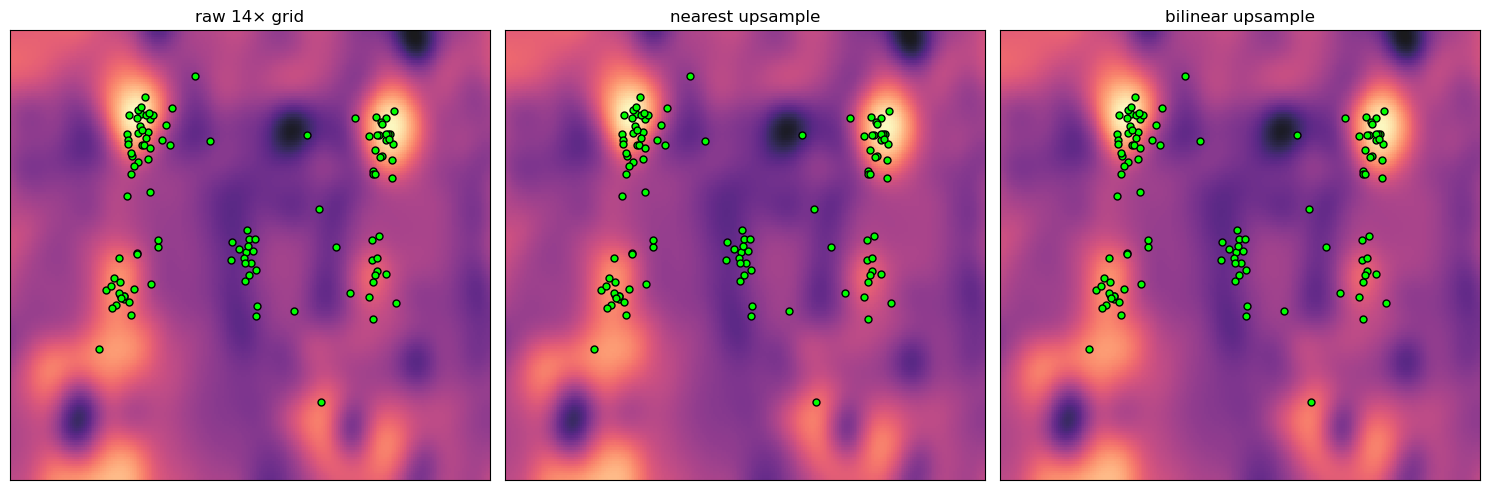

In [24]:
import torch, torch.nn.functional as F, matplotlib.pyplot as plt
import cloudpickle as cp
from pathlib import Path
from PIL import Image
from torchvision.transforms.functional import to_tensor

# ─── stimulus & CB ────────────────────────────────────────────────
img   = Image.open(image_path).convert("RGB")
H,W   = img.height, img.width
img_t = to_tensor(img).unsqueeze(0).to(device)

cb = torch.zeros((1, H, W), device=device)  # FULL RES  ← correct!
assert cb.shape[1:] == torch.Size([H, W]),  "centre-bias must be (1,H,W)"

# ─── forward & three visualisations ───────────────────────────────
# quick fix for inspection only
with torch.no_grad():
    model.finalizer.center_bias_weight.clamp_(0.1)   # force non-negative
with torch.no_grad():
    dens = model(img_t, cb).exp()                               # (1,H',W')
coarse        = dens.squeeze(0).cpu().numpy()
nearest_full  = F.interpolate(dens.unsqueeze(1), (H,W), mode="nearest") \
                  .squeeze().cpu().numpy()
bilinear_full = F.interpolate(dens.unsqueeze(1), (H,W), mode="bilinear",
                              align_corners=False) \
                  .squeeze().cpu().numpy()

idx = stimuli.filenames.index(stimuli.filenames[n])
xs,ys = fixations.x[fixations.n==idx], fixations.y[fixations.n==idx]

# ─── plot ─────────────────────────────────────────────────────────
fig,ax = plt.subplots(1,3,figsize=(15,5))
for a,heat,title in zip(ax,
        [coarse, nearest_full, bilinear_full],
        ["raw 14× grid","nearest upsample","bilinear upsample"]):
    a.imshow(heat,
         cmap="magma_r",
         alpha=.9,
         extent=[0, W, H, 0],
         origin="upper",
         interpolation="nearest",
         aspect="auto")     # <‑‑ this stretches the array to full height


    a.scatter(xs,ys,s=25,c='lime',edgecolors='k')
    a.set_xticks([]); a.set_yticks([]); a.set_title(title)
plt.tight_layout(); plt.show()


In [25]:
xs, ys   = fixations.x[fixations.n == idx], fixations.y[fixations.n == idx]

xs_int = np.floor(xs).astype(int)
ys_int = np.floor(ys).astype(int)

print("xs in image?", (xs_int >= 0).all() & (xs_int < W).all())
print("ys in image?", (ys_int >= 0).all() & (ys_int < H).all())

bad = np.where((ys < 0) | (ys >= H))[0]
print(f"{len(bad)} offending samples →", ys[bad][:10])

bad = np.where((xs < 0) | (xs >= W))[0]
print(f"{len(bad)} offending samples →", xs[bad][:10])

with open(conv_dir / "scanpaths_twosize.pkl", "rb") as f:
    scanpaths = cp.load(f)
print(scanpaths.y.max())          # should be < 768 after the fix



xs in image? True
ys in image? True
0 offending samples → []
0 offending samples → []
1022.9677419354838


Plotting 114 fixations after filtering for bounds.


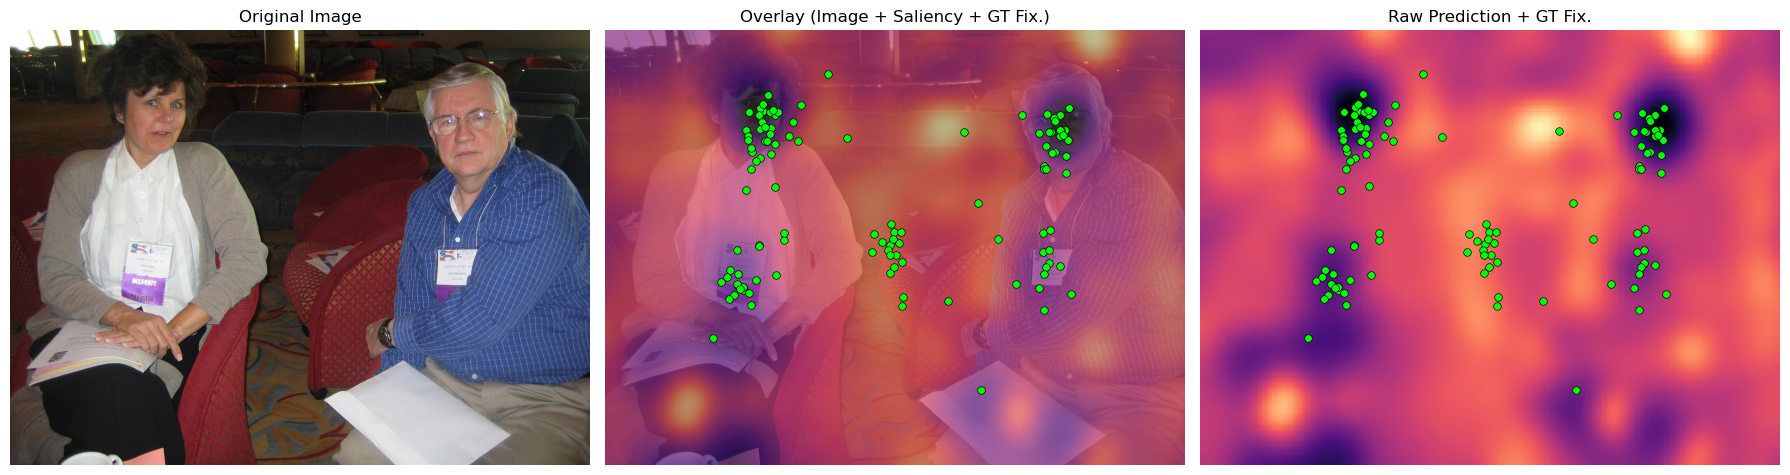

mean prob @ 114 valid fixation(s) (from bilinear map) = 1.2114826e-06  | global max (bilinear map) = 1.4220524e-06


In [26]:
import torch, torch.nn.functional as F, matplotlib.pyplot as plt
import cloudpickle as cp
from pathlib import Path
from PIL import Image
from torchvision.transforms.functional import to_tensor
import numpy as np # Ensure numpy is imported

# ─── stimulus & CB ────────────────────────────────────────────────
# (Keep this part the same as before)
img   = Image.open(image_path).convert("RGB")
H,W   = img.height, img.width
img_t = to_tensor(img).unsqueeze(0).to(device)

cb = torch.zeros((1, H, W), device=device)  # FULL RES
assert cb.shape[1:] == torch.Size([H, W]),  "centre-bias must be (1,H,W)"

# ─── forward pass & generate heatmaps ───────────────────────────
with torch.no_grad():
    # Optional: force non-negative weights if needed
    # model.finalizer.center_bias_weight.clamp_(0.1)
    dens = model(img_t, cb).exp()                               # (1, H', W') - Low resolution density

# 1. Raw (coarse) heatmap
coarse = dens.squeeze(0).cpu().numpy()                          # (H', W')

# 2. Bilinear upsampled heatmap (for overlay)
bilinear_full = F.interpolate(dens.unsqueeze(1), (H,W), mode="bilinear",
                              align_corners=False) \
                  .squeeze().cpu().numpy()                      # (H, W)

# ─── Get Fixations ────────────────────────────────────────────────

xs_int = np.round(xs).astype(int)
ys_int = np.round(ys).astype(int)
valid_x_plot = (xs_int >= 0) & (xs_int < W)
valid_y_plot = (ys_int >= 0) & (ys_int < H)
valid_plot_indices = valid_x_plot & valid_y_plot
xs_safe_plot = xs[valid_plot_indices] # Use original floats but only valid ones
ys_safe_plot = ys[valid_plot_indices]

print(f"Plotting {len(xs_safe_plot)} fixations after filtering for bounds.")


# ─── plot: Original | Overlay | Raw Saliency + Points ───────────
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# 1. Original Image
ax[0].imshow(img)
ax[0].set_title("Original Image")
ax[0].axis('off')

# 2. Overlayed Image with Mask (Saliency Heatmap) and Points
ax[1].imshow(img)
ax[1].imshow(bilinear_full, cmap="magma", alpha=0.7,
             extent=[0, W, H, 0], origin="upper", interpolation="bilinear")
ax[1].scatter(xs_safe_plot, ys_safe_plot, s=30, c='lime', edgecolors='k', linewidths=0.5)
ax[1].set_title("Overlay (Image + Saliency + GT Fix.)")
ax[1].axis('off')

# 3. Raw Saliency Map and Points
# Display the coarse heatmap, stretching it to the full image extent
# Use 'nearest' interpolation to see the actual low-resolution blocks
im = ax[2].imshow(coarse, cmap='magma', extent=[0, W, H, 0],
                  origin="upper", interpolation='nearest')
# Plot fixation points on top
ax[2].scatter(xs_safe_plot, ys_safe_plot, s=30, c='lime', edgecolors='k', linewidths=0.5) # Lime points for contrast on magma
ax[2].set_title("Raw Prediction + GT Fix.")
ax[2].axis('off')
# Optional: Add a colorbar for the raw prediction map
# fig.colorbar(im, ax=ax[2], fraction=0.046, pad=0.04) # Adjust fraction/pad as needed

plt.tight_layout()
plt.show()

# --- Optional: Display the numeric check again if desired ---
# (Using bilinear_full as it's the higher-resolution one where fixations land)
valid_idxs_x = (xs.round().astype(int) >= 0) & (xs.round().astype(int) < W)
valid_idxs_y = (ys.round().astype(int) >= 0) & (ys.round().astype(int) < H)
valid_fix_indices = valid_idxs_x & valid_idxs_y

if np.any(valid_fix_indices):
    idxs_x = xs[valid_fix_indices].round().astype(int)
    idxs_y = ys[valid_fix_indices].round().astype(int)
    print(f"mean prob @ {len(idxs_x)} valid fixation(s) (from bilinear map) =", bilinear_full[idxs_y, idxs_x].mean(),
          f" | global max (bilinear map) =", bilinear_full.max())
else:
    print("No valid fixation points found within image bounds for numeric check.")